Epoch 1/50


c:\Users\mynam\Downloads\DEEP LEARNING I\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.1810 - val_loss: 0.4246
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0913 - val_loss: 0.2640
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0498 - val_loss: 0.1539
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0548 - val_loss: 0.0996
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0483 - val_loss: 0.0858
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0511 - val_loss: 0.0951
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0471 - val_loss: 0.1113
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0441 - val_loss: 0.1240
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0360 - val_loss: 0.1277
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0401 - val_loss: 0.1254
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0390 - val_loss: 0.1148
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0326 - val_loss: 0.0981
Epoch 13/50

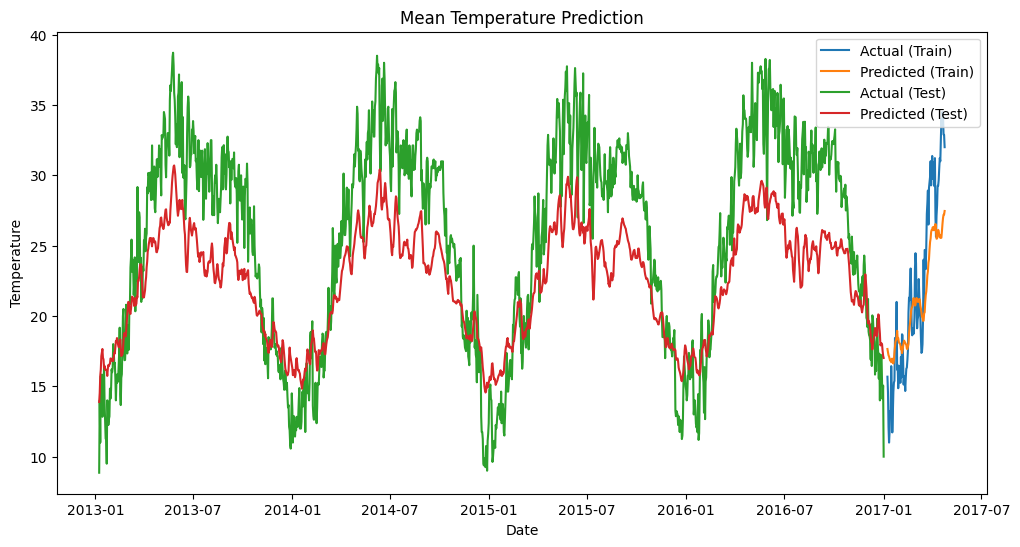

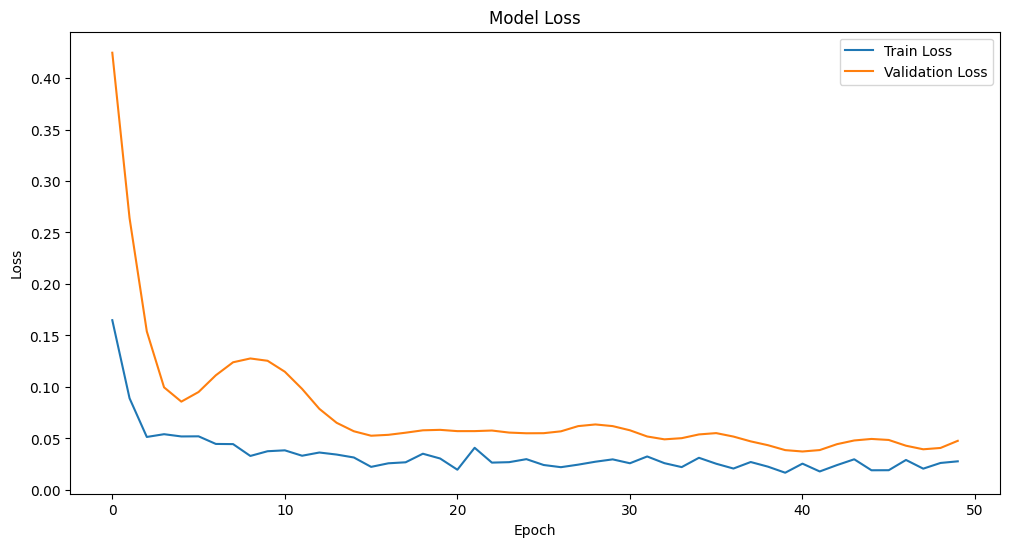

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the data
train_data = pd.read_csv('./DailyDelhiClimateTest.csv')
test_data = pd.read_csv('./DailyDelhiClimateTrain.csv')

# Convert date to datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

# Sort data by date
train_data = train_data.sort_values('date')
test_data = test_data.sort_values('date')

# Select features for the model
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

# Normalize the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(test_data[features])

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])  # Predicting mean temperature
    return np.array(X), np.array(y)

# Create sequences
seq_length = 7  # Use past 7 days to predict the next day
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Build the RNN model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(seq_length, len(features))),
    Dense(1)
])

# Build SimpleRNN model
def build_rnn_model():
    model = Sequential([
        SimpleRNN(50, activation='relu',
                  input_shape=(seq_length, len(features)),
                  return_sequences=False,  # Output only the last step
                  dropout=0.2,             # Dropout for input connections
                  recurrent_dropout=0.2),  # Dropout for recurrent connections
        Dense(1)
    ])
    return model

# Build LSTM model
def build_lstm_model():
    model = Sequential([
        LSTM(50, activation='tanh',        # Commonly 'tanh' is used in LSTMs
             input_shape=(seq_length, len(features)),
             return_sequences=False,       # Can be True if stacking LSTM layers
             dropout=0.2,                  # Dropout for input connections
             recurrent_dropout=0.2),       # Dropout for recurrent connections (memory)
        Dense(1)
    ])
    return model

# Build GRU model
def create_gru_model():
    model = Sequential([
        GRU(50, activation='relu',
            input_shape=(seq_length, len(features)),
            return_sequences=False,       # Set True if using multiple GRU layers
            dropout=0.2,                  # Dropout for input connections
            recurrent_dropout=0.2),       # Dropout for recurrent connections
        Dense(1)
    ])
    return model

model = build_lstm_model()


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train MSE: {train_loss:.4f}')
print(f'Test MSE: {test_loss:.4f}')

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

def inverse_transform_predictions(scaler, predictions, actual_values):
    """
    Inverse transform scaled predictions and actual values.

    Args:
    scaler (MinMaxScaler): The fitted scaler used for normalization
    predictions (np.array): Scaled predictions
    actual_values (np.array): Scaled actual values

    Returns:
    tuple: Inverse transformed predictions and actual values
    """
    try:
        # Ensure the scaler has been fitted
        if not hasattr(scaler, 'n_features_in_'):
            raise ValueError("Scaler has not been fitted. Please fit the scaler before using it.")

        # Get the number of features the scaler expects
        num_features = scaler.n_features_in_

        # Reshape inputs to 2D if they're 1D
        predictions = predictions.reshape(-1, 1) if predictions.ndim == 1 else predictions
        actual_values = actual_values.reshape(-1, 1) if actual_values.ndim == 1 else actual_values

        # Create arrays with zeros for other features
        pred_with_zeros = np.column_stack((predictions, np.zeros((len(predictions), num_features - 1))))
        actual_with_zeros = np.column_stack((actual_values, np.zeros((len(actual_values), num_features - 1))))

        # Perform inverse transform
        inv_predictions = scaler.inverse_transform(pred_with_zeros)[:, 0]
        inv_actual_values = scaler.inverse_transform(actual_with_zeros)[:, 0]

        return inv_predictions, inv_actual_values

    except Exception as e:
        print(f"Error in inverse transformation: {str(e)}")
        return None, None

# Usage:
try:
    train_pred, y_train_actual = inverse_transform_predictions(scaler, train_pred, y_train)
    test_pred, y_test_actual = inverse_transform_predictions(scaler, test_pred, y_test)

    if train_pred is None or test_pred is None:
        raise ValueError("Inverse transformation failed")

    print("Inverse transformation successful")
except Exception as e:
    print(f"An error occurred: {str(e)}")




# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'][seq_length:], y_train_actual, label='Actual (Train)')
plt.plot(train_data['date'][seq_length:], train_pred, label='Predicted (Train)')
plt.plot(test_data['date'][seq_length:], y_test_actual, label='Actual (Test)')
plt.plot(test_data['date'][seq_length:], test_pred, label='Predicted (Test)')
plt.title('Mean Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()